In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Tell Tensorflow to use no more GPU RAM than necessaey

In [2]:
import keras .backend as K

K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

Using TensorFlow backend.


In [3]:
import numpy as np
import bcolz
import threading

class BcolzArrayIterator(object):
    """
    Returns an iterator object into Bcolz carray files
    Original version by Thiago Ramon Gonçalves Montoya
    Docs (and discovery) by @MPJansen
    Refactoring, performance improvements, fixes by Jeremy Howard j@fast.ai
        :Example:
        X = bcolz.open('file_path/feature_file.bc', mode='r')
        y = bcolz.open('file_path/label_file.bc', mode='r')
        trn_batches = BcolzArrayIterator(X, y, batch_size=64, shuffle=True)
        model.fit_generator(generator=trn_batches, samples_per_epoch=trn_batches.N, nb_epoch=1)
        :param X: Input features
        :param y: (optional) Input labels
        :param w: (optional) Input feature weights
        :param batch_size: (optional) Batch size, defaults to 32
        :param shuffle: (optional) Shuffle batches, defaults to false
        :param seed: (optional) Provide a seed to shuffle, defaults to a random seed
        :rtype: BcolzArrayIterator
        >>> A = np.random.random((32*10 + 17, 10, 10))
        >>> c = bcolz.carray(A, rootdir='test.bc', mode='w', expectedlen=A.shape[0], chunklen=16)
        >>> c.flush()
        >>> Bc = bcolz.open('test.bc')
        >>> bc_it = BcolzArrayIterator(Bc, shuffle=True)
        >>> C_list = [next(bc_it) for i in range(11)]
        >>> C = np.concatenate(C_list)
        >>> np.allclose(sorted(A.flatten()), sorted(C.flatten()))
        True
    """

    def __init__(self, X, y=None, w=None, batch_size=32, shuffle=False, seed=None):
        if y is not None and len(X) != len(y):
            raise ValueError('X (features) and y (labels) should have the same length'
                             'Found: X.shape = %s, y.shape = %s' % (X.shape, y.shape))
        if w is not None and len(X) != len(w):
            raise ValueError('X (features) and w (weights) should have the same length'
                             'Found: X.shape = %s, w.shape = %s' % (X.shape, w.shape))
        if batch_size % X.chunklen != 0:
            raise ValueError('batch_size needs to be a multiple of X.chunklen')

        self.chunks_per_batch = batch_size // X.chunklen
        self.X = X
        self.y = y if y is not None else None
        self.w = w if w is not None else None
        self.N = X.shape[0]
        self.batch_size = batch_size
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.shuffle = shuffle
        self.seed = seed


    def reset(self): self.batch_index = 0


    def next(self):
        with self.lock:
            if self.batch_index == 0:
                if self.seed is not None:
                    np.random.seed(self.seed + self.total_batches_seen)
                self.index_array = (np.random.permutation(self.X.nchunks + 1) if self.shuffle
                    else np.arange(self.X.nchunks + 1))

            #batches_x = np.zeros((self.batch_size,)+self.X.shape[1:])
            batches_x, batches_y, batches_w = [],[],[]
            for i in range(self.chunks_per_batch):
                current_index = self.index_array[self.batch_index]
                if current_index == self.X.nchunks:
                    batches_x.append(self.X.leftover_array[:self.X.leftover_elements])
                    current_batch_size = self.X.leftover_elements
                else:
                    batches_x.append(self.X.chunks[current_index][:])
                    current_batch_size = self.X.chunklen
                self.batch_index += 1
                self.total_batches_seen += 1

                idx = current_index * self.X.chunklen
                if not self.y is None: batches_y.append(self.y[idx: idx + current_batch_size])
                if not self.w is None: batches_w.append(self.w[idx: idx + current_batch_size])
                if self.batch_index >= len(self.index_array):
                    self.batch_index = 0
                    break

            batch_x = np.concatenate(batches_x)
            if self.y is None: return batch_x

            batch_y = np.concatenate(batches_y)
            if self.w is None: return batch_x, batch_y

            batch_w = np.concatenate(batches_w)
            return batch_x, batch_y, batch_w


    def __iter__(self): return self

    def __next__(self, *args, **kwargs): return self.next(*args, **kwargs)

In [4]:
from gensim.models import word2vec

In [5]:
model = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

In [9]:
lines = open('GoogleNews-vectors-negative300.txt').readlines()

In [10]:
def parse_w2v(l):
    i=l.index(' ')
    return l[:i], np.fromstring(l[i+1:-2], 'float32', sep=' ')

w2v_list = list(map(parse_w2v, lines[1:]))

In [6]:
import pickle

In [12]:
pickle.dump(w2v_list, open('w2vl.pkl', 'wb'))

In [7]:
w2v_list = pickle.load(open('w2vl.pkl', 'rb'))

In [8]:
w2v_dict = dict(w2v_list)
words,vectors = zip(*w2v_list)

In [15]:
np.corrcoef(w2v_dict['jeremy'], w2v_dict['Jeremy'])

array([[ 1.        ,  0.16497618],
       [ 0.16497618,  1.        ]])

In [16]:
np.corrcoef(w2v_dict['banana'], w2v_dict['Jeremy'])

array([[ 1.        ,  0.01871472],
       [ 0.01871472,  1.        ]])

In [9]:
lc_w2v = {w.lower(): w2v_dict[w] for w in reversed(words)}

https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [10]:
import json

In [11]:
class_dict = json.load(open('imagenet_class_index.json'))
nclass = len(class_dict); nclass

1000

In [12]:
classids_1k = dict(class_dict.values())

### download wordnet and generate classids.txt
```
import nltk
nltk.download()
> d
> wordnet
> q
```

In [21]:
import nltk
import os
wordnet_nouns = list(nltk.corpus.wordnet.all_synsets(pos='n'))
with open(os.path.join('classids.txt'), 'w') as f:
    f.writelines(['n{:08d} {}\n'.format(n.offset(), n.name().split('.')[0]) for n in wordnet_nouns])

In [13]:
classid_lines = open('classids.txt', 'r').readlines()
classids = dict(l.strip().split(' ') for l in classid_lines)
len(classids)

82115

In [14]:
syn_wv = [(k, lc_w2v[v.lower()]) for k,v in classids.items()
          if v.lower() in lc_w2v]
syn_wv_1k = [(k, lc_w2v[v.lower()]) for k,v in classids_1k.items()
          if v.lower() in lc_w2v]
syn2wv = dict(syn_wv); len(syn2wv)

51640

In [15]:
nomatch = [v[0] for v in class_dict.values() if v[0] not in syn2wv]

In [16]:
ndim = len(list(syn2wv.values())[0]); ndim

300

## resize images

In [17]:
import glob

In [27]:
fnames = list(glob.iglob('train/*/*.JPEG'))
pickle.dump(fnames, open('fnames.pkl', 'wb'))

In [18]:
fnames = pickle.load(open('fnames.pkl', 'rb'))

In [29]:
fnames = np.random.permutation(fnames)

In [30]:
pickle.dump(fnames, open('fnames_r.pkl', 'wb'))

In [19]:
fnames = pickle.load(open('fnames_r.pkl', 'rb'))

In [20]:
new_s = 224 # height and width to resize to
n = len(fnames); n

19439

Using pillow to resize the image (recommendation: install pillow-simd for 600% speedup). To install, force remove the conda installed version, then:
```
CC="cc -mavx2" pip install -U --force-reinstall pillow-simd
```

In [21]:
from PIL import Image

In [22]:
def _resize(img):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

In [23]:
def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: return
    return _resize(img)

In [24]:
def resize_img_bw(i):
    return _resize(Image.open(fnames[i]).convert('L'))  # grayscale

In [25]:
tl = threading.local()

In [38]:
tl.place = np.zeros((new_s,new_s,3), 'uint8')
#tl.place = np.zeros((new_s,new_s), 'uint8')

In [101]:
arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), 
                   chunklen=16, mode='w', rootdir='trn_resized_{new_s}_r.bc')

In [40]:
def get_slice(p, n):
    return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    tl.place[:] = (np.array(r)[get_slice(r.size[1],new_s), get_slice(r.size[0],new_s)] 
        if r else 0.)
    arr.append(tl.place)

### Serial version
```
for i in tqdm(range(2000)):
    app_img(resize_img(i))
arr.flush()
```

In [42]:
from concurrent.futures import ThreadPoolExecutor

### Parallel version

In [102]:
step=6400
for i in tqdm(range(0, n, step)):
    with ThreadPoolExecutor(max_workers=16) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res: app_img(r)
    arr.flush()

100%|██████████| 4/4 [01:18<00:00, 19.51s/it]


In [26]:
arr = bcolz.open('trn_resized_{new_s}_r.bc')

In [27]:
import matplotlib.pyplot as plt

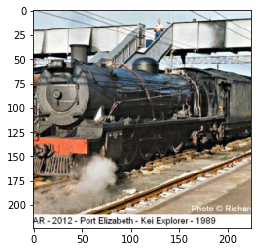

In [49]:
plt.imshow(arr[-2].astype('uint8'))

## create model

In [28]:
def get_synset(f):
    return f[f.rfind('/')+1:f.find('_')]

labels = list(map(get_synset, fnames))
labels[:5]

['n03840681', 'n02398521', 'n02483362', 'n03255030', 'n03376595']

In [29]:
vecs = np.stack([syn2wv[l] for l in labels]); vecs.shape

(19439, 300)

In [30]:
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense
from keras.layers import AveragePooling2D
from keras.layers.core import Lambda
from keras.applications.resnet50 import ResNet50, identity_block, conv_block
K.set_image_dim_ordering('tf')

In [31]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
inp = Input((224,224,3))
preproc = Lambda(lambda x: (x - rn_mean))(inp)
model = ResNet50(include_top=False, input_tensor=preproc)

In [32]:
mid_start = model.get_layer('res5b_branch2a')
mid_out = model.layers[model.layers.index(mid_start)-1]
shp=mid_out.output_shape; shp

(None, 7, 7, 2048)

In [33]:
rn_top = Model(model.input, mid_out.output)
rn_top_avg = Sequential([rn_top, AveragePooling2D((7,7))])
shp=rn_top_avg.output_shape; shp

(None, 1, 1, 2048)

https://github.com/Blosc/bcolz/blob/master/docs/tutorial_carray.ipynb

In [74]:
features_mid = bcolz.carray(np.empty((0,)+shp[1:]), rootdir='features_mid_1c_r.bc',
                           chunklen=16, mode='w')

In [34]:
features_mid = bcolz.open('features_mid_1c_r.bc')

In [104]:
def gen_features_mid(dirn):
    gen = (arr[i:min(i+128,n)] for i in range(0, n, 128))
    for i,batch in tqdm(enumerate(gen)):
        features_mid.append(rn_top_avg.predict(batch[:,:,::dirn]))
        if (i%100==99): features_mid.flush()
    features_mid.flush()

In [105]:
gen_features_mid(1)

152it [03:54,  1.54s/it]


In [35]:
features_mid.shape

(19439, 1, 1, 2048)

In [36]:
rn_bot_inp = Input(shp[1:])
x = rn_bot_inp
# x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
# x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
x = Flatten()(x)
rn_bot = Model(rn_bot_inp, x)
rn_bot.output_shape

(None, 2048)

In [37]:
for i in range(len(rn_bot.layers)-2):
    rn_bot.layers[-i-2].set_weights(model.layers[-i-2].get_weights())

In [111]:
%time features_last = rn_bot.predict(features_mid, batch_size=128)

CPU times: user 1.49 s, sys: 256 ms, total: 1.74 s
Wall time: 2.31 s


In [112]:
features_last = bcolz.carray(features_last, rootdir='features_last_r.bc', 
                             chunklen=64, mode='w')

In [38]:
features_last = bcolz.open('features_last_r.bc')[:]

In [39]:
lm_inp = Input(shape=(2048,))
lm = Model(lm_inp, Dense(ndim)(lm_inp))

In [40]:
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

In [41]:
lm.compile('adam','cosine_proximity')

In [118]:
lm.evaluate(features_last, vecs, verbose=1)

18976/19439 [============================>.] - ETA: 0s

3.3795918099396974e-05

In [123]:
lm.fit(features_last, vecs, verbose=2, epochs=3)

Epoch 1/3
4s - loss: -1.7127e-03
Epoch 2/3
4s - loss: -1.7343e-03
Epoch 3/3
4s - loss: -1.7492e-03


In [125]:
lm.save_weights('lm_cos.h5')

In [42]:
lm.load_weights('lm_cos.h5')

## Nearest Neighbors

In [43]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

In [44]:
from sklearn.neighbors import NearestNeighbors, LSHForest

In [45]:
nn = NearestNeighbors(3, metric='cosine', algorithm='brute').fit(wvs)

In [135]:
# nn = LSHForest(20, n_neighbors=3).fit(wvs)
# LSHForest has poor performance and has been deprecated in 0.19

In [60]:
%time pred_wv = lm.predict(features_last[:10000])

CPU times: user 580 ms, sys: 40 ms, total: 620 ms
Wall time: 496 ms


In [61]:
%time dist, idxs = nn.kneighbors(pred_wv)

CPU times: user 204 ms, sys: 20 ms, total: 224 ms
Wall time: 125 ms


In [143]:
[[classids[syns[id]] for id in ids] for ids in idxs[190:200]]

[['indigo_bunting', 'proboscis_monkey', 'redshank'],
 ['indigo_bunting', 'border_terrier', 'bluetick'],
 ['komodo_dragon', 'bull_mastiff', 'irish_wolfhound'],
 ['wolf_spider', 'isopod', 'rhinoceros_beetle'],
 ['washbasin', 'tub', 'bookcase'],
 ['acoustic_guitar', 'electric_guitar', 'cello'],
 ['standard_poodle', 'miniature_poodle', 'pekinese'],
 ['border_collie', 'golden_retriever', 'samoyed'],
 ['coffeepot', 'birdhouse', 'lampshade'],
 ['trilobite', 'border_terrier', 'kelpie']]

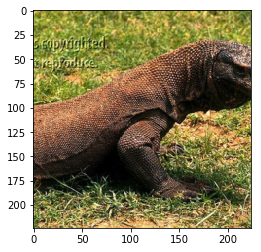

In [151]:
plt.imshow(arr[192].astype('uint8'))

In [46]:
all_syns, all_wvs = list(zip(*syn_wv))
all_wvs = np.array(all_wvs)

In [47]:
all_nn = NearestNeighbors(3, metric='cosine', algorithm='brute').fit(all_wvs)

In [148]:
%time dist, idxs = all_nn.kneighbors(pred_wv[:200])

CPU times: user 428 ms, sys: 60 ms, total: 488 ms
Wall time: 291 ms


In [149]:
[[classids[all_syns[id]] for id in ids] for ids in idxs[190:200]]

[['binturong', 'coati', 'andean_condor'],
 ['horned_owl', 'northern_shrike', 'scarlet_tanager'],
 ['komodo_dragon', 'bull_mastiff', 'binturong'],
 ['wolf_spider', 'stag_beetle', 'isopod'],
 ['washbasin', 'washbasin', 'corncrib'],
 ['acoustic_guitar', 'electric_guitar', 'guitar'],
 ['standard_poodle', 'miniature_poodle', 'pekinese'],
 ['border_collie', 'golden_retriever', 'samoyed'],
 ['darning_needle', 'dishpan', 'needlenose_pliers'],
 ['binturong', 'trilobite', 'insectivore']]

## fine tune

In [48]:
lm_inp2 = Input(shape=(2048,))
lm2 = Model(lm_inp2, Dense(ndim)(lm_inp2))

In [49]:
for l1,l2 in zip(lm.layers,lm2.layers): l2.set_weights(l1.get_weights())

In [50]:
rn_bot_seq = Sequential([rn_bot, lm2])
rn_bot_seq.compile('adam', 'cosine_proximity')
rn_bot_seq.output_shape

(None, 300)

In [156]:
bc_it = BcolzArrayIterator(features_mid, vecs, shuffle=True, batch_size=128)

In [157]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-3)

In [158]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose=2, epochs=4)

Epoch 1/4
678s - loss: -3.1323e-03
Epoch 2/4
673s - loss: -3.2593e-03
Epoch 3/4
673s - loss: -3.2716e-03
Epoch 4/4
673s - loss: -3.2773e-03


In [159]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-4)

In [160]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose=2, epochs=8)

Epoch 1/8
678s - loss: -3.2872e-03
Epoch 2/8
675s - loss: -3.2899e-03
Epoch 3/8
673s - loss: -3.2913e-03
Epoch 4/8
674s - loss: -3.2932e-03
Epoch 5/8
673s - loss: -3.2956e-03
Epoch 6/8
674s - loss: -3.2979e-03
Epoch 7/8
678s - loss: -3.2998e-03
Epoch 8/8
675s - loss: -3.3014e-03


In [161]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-5)

In [162]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose=2, epochs=5)

Epoch 1/5
673s - loss: -3.3026e-03
Epoch 2/5
675s - loss: -3.3027e-03
Epoch 3/5
676s - loss: -3.3029e-03
Epoch 4/5
677s - loss: -3.3031e-03
Epoch 5/5
673s - loss: -3.3032e-03


In [163]:
rn_bot_seq.evaluate(features_mid, vecs, verbose=2)

-0.0032861662197694627

In [164]:
rn_bot_seq.save_weights('rn_bot_seq_cos.h5')

In [51]:
rn_bot_seq.load_weights('rn_bot_seq_cos.h5')

## KNN again

In [52]:
%time pred_wv = rn_bot_seq.predict(features_mid)

CPU times: user 5.01 s, sys: 524 ms, total: 5.54 s
Wall time: 2min 5s


In [53]:
rng = slice(190,200)

In [54]:
dist, idxs = nn.kneighbors(pred_wv[rng])

In [55]:
[[classids[syns[id]] for id in ids] for ids in idxs]

[['partridge', 'peacock', 'basset'],
 ['partridge', 'peacock', 'basset'],
 ['komodo_dragon', 'leatherback_turtle', 'orangutan'],
 ['rhinoceros_beetle', 'lacewing', 'wolf_spider'],
 ['washbasin', 'tub', 'soap_dispenser'],
 ['electric_guitar', 'acoustic_guitar', 'harmonica'],
 ['chihuahua', 'pomeranian', 'border_collie'],
 ['miniature_schnauzer', 'golden_retriever', 'cocker_spaniel'],
 ['crate', 'border_terrier', 'basenji'],
 ['border_terrier', 'tibetan_terrier', 'irish_setter']]

In [56]:
dist, idxs = all_nn.kneighbors(pred_wv[rng])

In [57]:
[[classids[all_syns[id]] for id in ids] for ids in idxs]

[['partridge', 'partridge', 'peacock'],
 ['partridge', 'partridge', 'peacock'],
 ['komodo_dragon', 'leatherback_turtle', 'mammal'],
 ['rhinoceros_beetle', 'tomato_hornworm', 'cebus'],
 ['washbasin', 'washbasin', 'washstand'],
 ['electric_guitar', 'guitar', 'acoustic_guitar'],
 ['chihuahua', 'chihuahua', 'chihuahua'],
 ['miniature_schnauzer', 'golden_retriever', 'cocker_spaniel'],
 ['rabbit', 'rabbit', 'coati'],
 ['border_terrier', 'tibetan_terrier', 'irish_setter']]

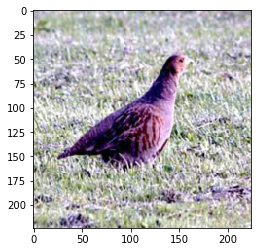

In [58]:
plt.imshow(arr[rng][1].astype('uint8'))

## Text -> Image

In [59]:
img_nn = NearestNeighbors(3, metric='cosine', algorithm='brute').fit(pred_wv)

In [62]:
word = 'boat'
vec = w2v_dict[word]
dist, idxs = img_nn.kneighbors(vec.reshape(1,-1))

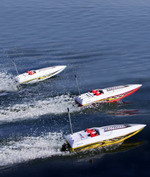

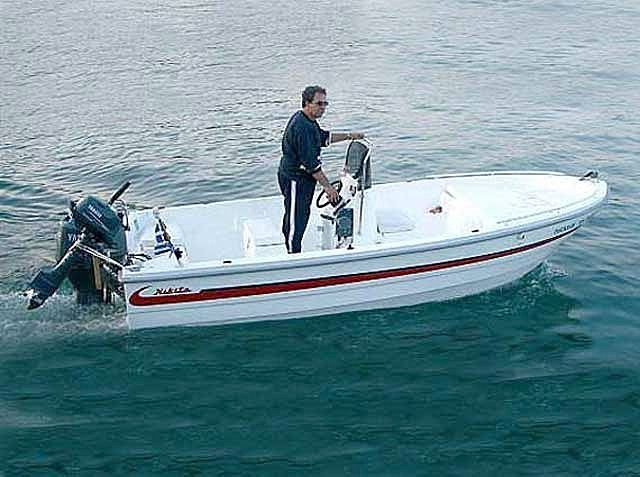

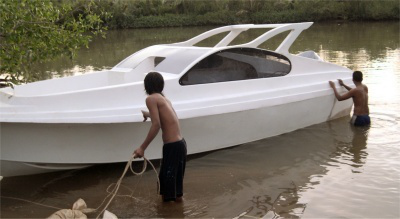

In [63]:
ims = [Image.open(fnames[fn]) for fn in idxs[0]]
display(*ims)

In [66]:
vec = (w2v_dict['paddle'] + w2v_dict['boat'])/2
dist, idxs = img_nn.kneighbors(vec.reshape(1,-1))

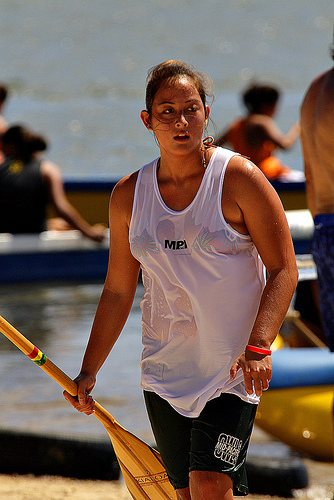

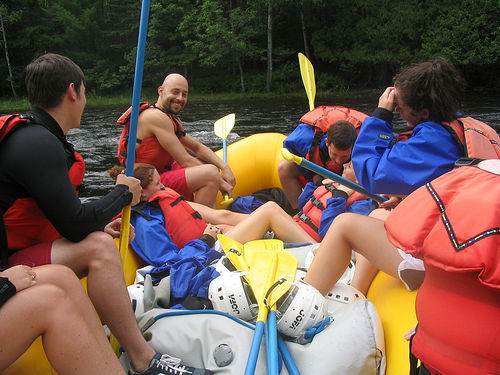

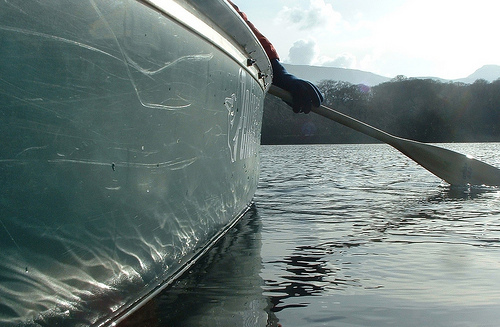

In [67]:
ims = [Image.open(fnames[fn]) for fn in idxs[0]]
display(*ims)

In [68]:
def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0: return low
    elif val >= 1: return high
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

In [69]:
vec = slerp(0.5, w2v_dict['paddle'], w2v_dict['boat'])
dist, idxs = img_nn.kneighbors(vec.reshape(1,-1))

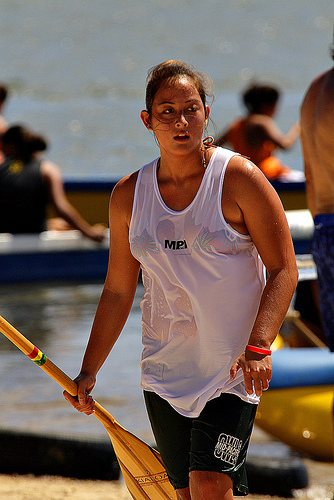

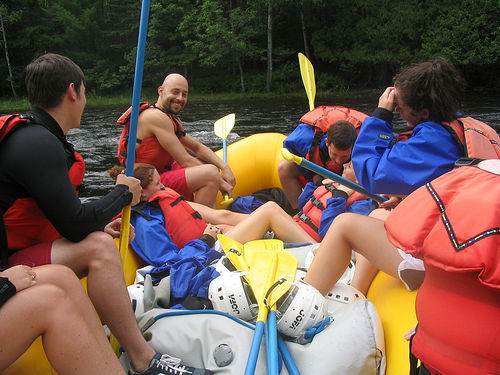

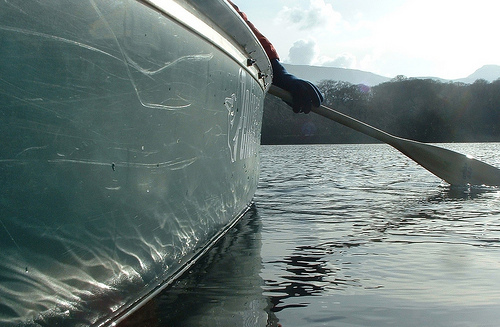

In [70]:
ims = [Image.open(fnames[fn]) for fn in idxs[0]]
display(*ims)

## Image -> Image

In [71]:
ft_model = Sequential([rn_top_avg, rn_bot_seq])

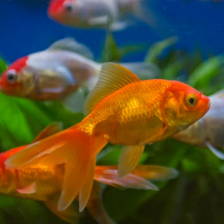

In [84]:
new_im = Image.open('fish2.jpg').resize((224,224), Image.BILINEAR); new_im

In [85]:
vec = ft_model.predict(np.expand_dims(new_im, 0))

In [86]:
dist, idxs = img_nn.kneighbors(vec)

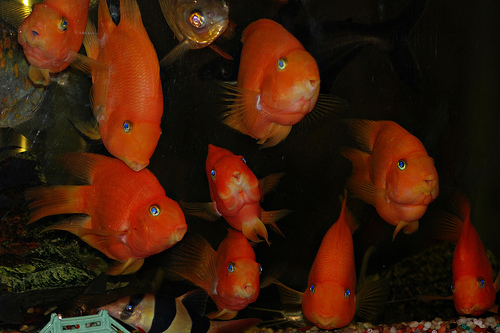

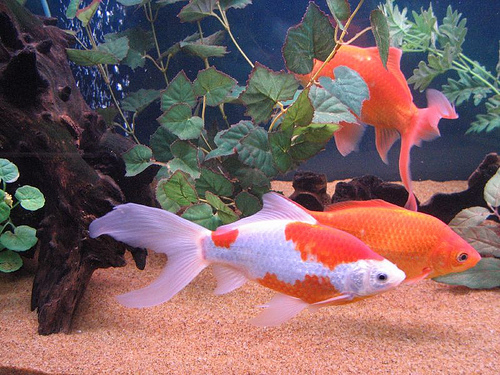

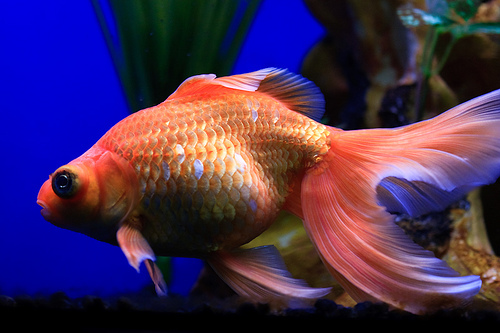

In [87]:
ims = [Image.open(fnames[fn]) for fn in idxs[0]]
display(*ims)

In [88]:
[[classids[all_syns[id]] for id in ids] for ids in idxs]

[['claw', 'parasol', 'toque']]